In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
from matplotlib import pyplot as plt


In [19]:
ds_dataset = pd.read_csv('cleaned_dataset_peter.csv', low_memory=False)

In [20]:
def ds_drop_unused(df):
    df = df.drop([
        'COURT_OUTCOME',
        'AMOUNT_FINED',
        'ROW_ID',
        'INSPECTION_ID',
        'MINIMUM_INSPECTIONS_PERYEAR',
    ], axis=1)    
    return df

def fix_names(df, cols):
    punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'   # `|` is not present here
    transtab = str.maketrans(dict.fromkeys(punct, ''))
    for col in cols:
        df[col] = '|'.join(df[col].tolist()).translate(transtab).split('|')
        df[col] = df[col].str.lower()
        df[col] = df[col].str.replace('coffee time donuts', 'coffee time')

    return df

In [21]:
dinesafe = ds_drop_unused(ds_dataset).astype({'ID': 'int32','NAME':'str'})
fix_names(dinesafe, ['NAME'])
dinesafe['DATE'] = pd.to_datetime(dinesafe['DATE'], errors='coerce')
dinesafe['Year'] = dinesafe['DATE'].dt.year

In [22]:
ds_grouped = (dinesafe.groupby(['Year', 'NAME'])
                      .agg(counts = ('ID', 'nunique'))
                      .sort_values(['Year', 'counts'], ascending=[False, False])
                      .reset_index())

In [23]:
ds_grouped[ds_grouped['Year']==2022]

,Year,NAME,counts
0,2022,tim hortons,317
1,2022,subway,194
2,2022,pizza pizza,98
3,2022,shoppers drug mart,77
4,2022,mcdonalds,70
...,...,...,...
10706,2022,zteca mexican eatery,1
10707,2022,zteca mexican eatery steeles tech,1
10708,2022,zula,1
10709,2022,zula market,1


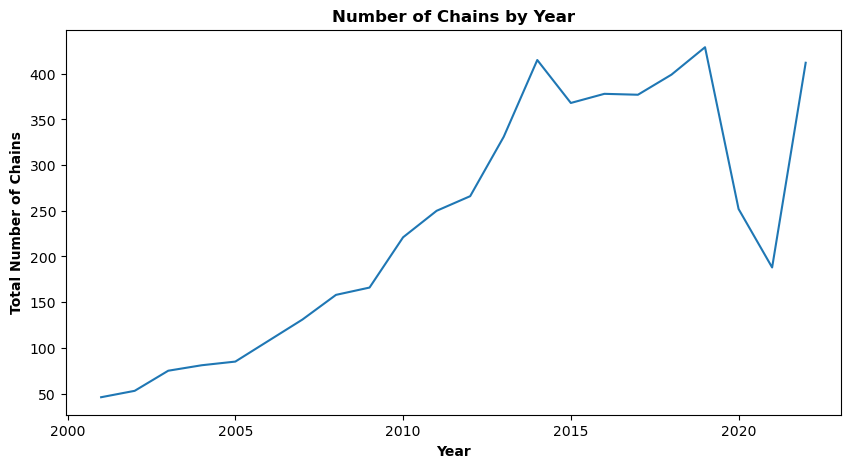

In [24]:
# Create plot of number of chains per year
num_chains = []
years = range(2001,2023)

for year in years:
    num_chain_year = len(ds_grouped[(ds_grouped['counts']>2)&(ds_grouped['Year']==year)])
    num_chains.append(num_chain_year)

num_chains = pd.DataFrame(data = num_chains, index=years, columns=['number_of_chains']).reset_index()

plt.figure(figsize=(10,5))
plt.title('Number of Chains by Year', fontsize='large', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Total Number of Chains', fontweight='bold')
sns.lineplot(data=num_chains, x='index',y='number_of_chains')
plt.show()

In [25]:
top_10_2022 = ds_grouped[ds_grouped['Year']==2022].head(10)['NAME']
top_10_df = ds_grouped[ds_grouped['NAME'].isin(top_10_2022)]

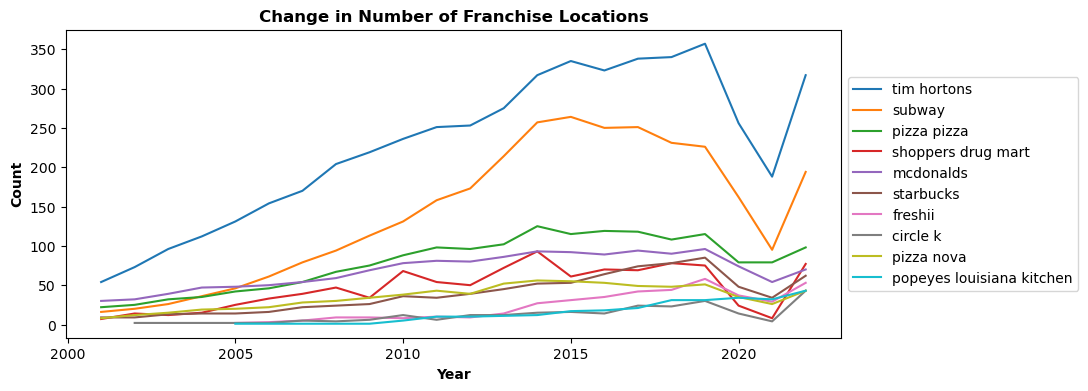

In [26]:
plt.figure(figsize=(10,4))
plt.title('Change in Number of Franchise Locations', fontsize='large', fontweight='bold')
sns.lineplot(data=top_10_df, x='Year', y='counts', hue='NAME')
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [27]:
ds_2022 = ds_grouped[(ds_grouped['Year']==2022)]
ds_2011 = ds_grouped[(ds_grouped['Year']==2011)]
ds_2001 = ds_grouped[(ds_grouped['Year']==2001)]
ds_2001 = ds_2001.rename(columns={
    'NAME':'chain',
    'counts':'counts_2001'
}).drop('Year', axis=1)
ds_2011 = ds_2011.rename(columns={
    'NAME':'chain',
    'counts':'counts_2011'
}).drop('Year', axis=1)
ds_2022 = ds_2022.rename(columns={
    'NAME':'chain',
    'counts':'counts_2022'
}).drop('Year', axis=1)

In [28]:
ds_growth = ds_2022.merge(
    ds_2001,
    how="inner",
    left_on=['chain'],
    right_on=['chain']
)
ds_growth = ds_growth.merge(
    ds_2011,
    how="inner",
    left_on=['chain'],
    right_on=['chain']
)

In [29]:
ds_growth['count_diff_2022_2001'] = ds_growth['counts_2022']-ds_growth['counts_2001']
ds_growth['count_diff_2022_2011'] = ds_growth['counts_2022']-ds_growth['counts_2011']

In [30]:
ds_growth_franchise = ds_growth.groupby('chain').agg(
    change_in_franchises_0122 = ('count_diff_2022_2001', 'sum'),
    change_in_franchises_1122 = ('count_diff_2022_2011', 'sum'),
    franchises_2001 = ('counts_2001', 'sum'),
    franchises_2022 = ('counts_2022', 'sum'),
    franchises_2011 = ('counts_2011', 'sum')
)

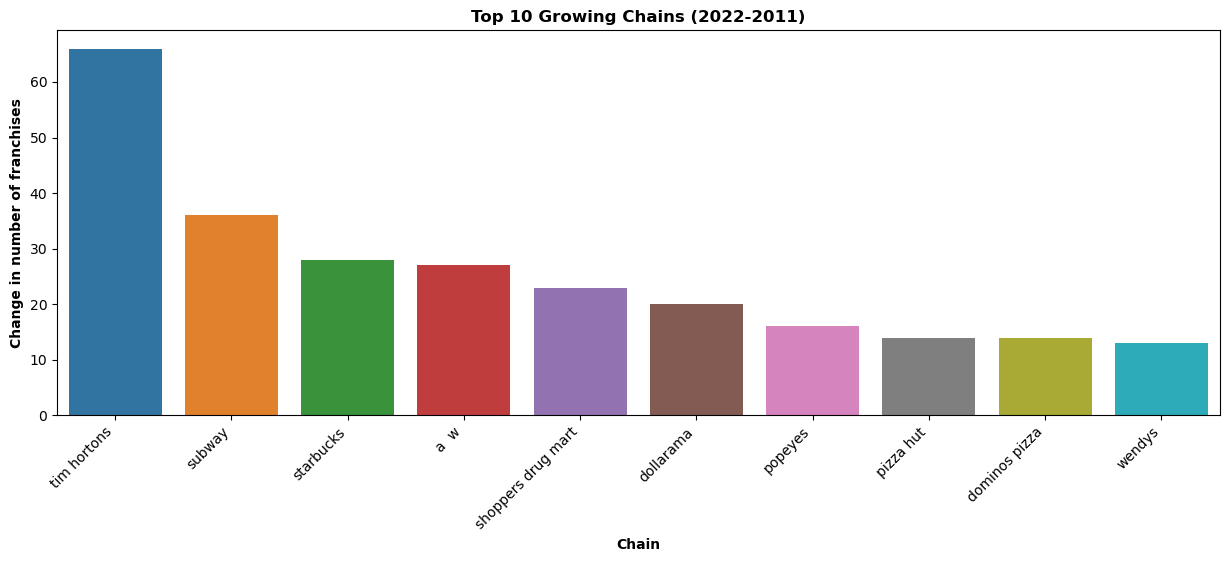

In [32]:
plt.figure(figsize=(15,5))
plt.title('Top 10 Growing Chains (2022-2011)', fontsize='large', fontweight='bold')
sns.barplot(data = ds_growth.sort_values('count_diff_2022_2011', ascending=False).head(10), x='chain', y='count_diff_2022_2011')
plt.xlabel('Chain', fontweight='bold')
plt.ylabel('Change in number of franchises', fontweight='bold')
plt.xticks(rotation=45,horizontalalignment='right')
plt.show()

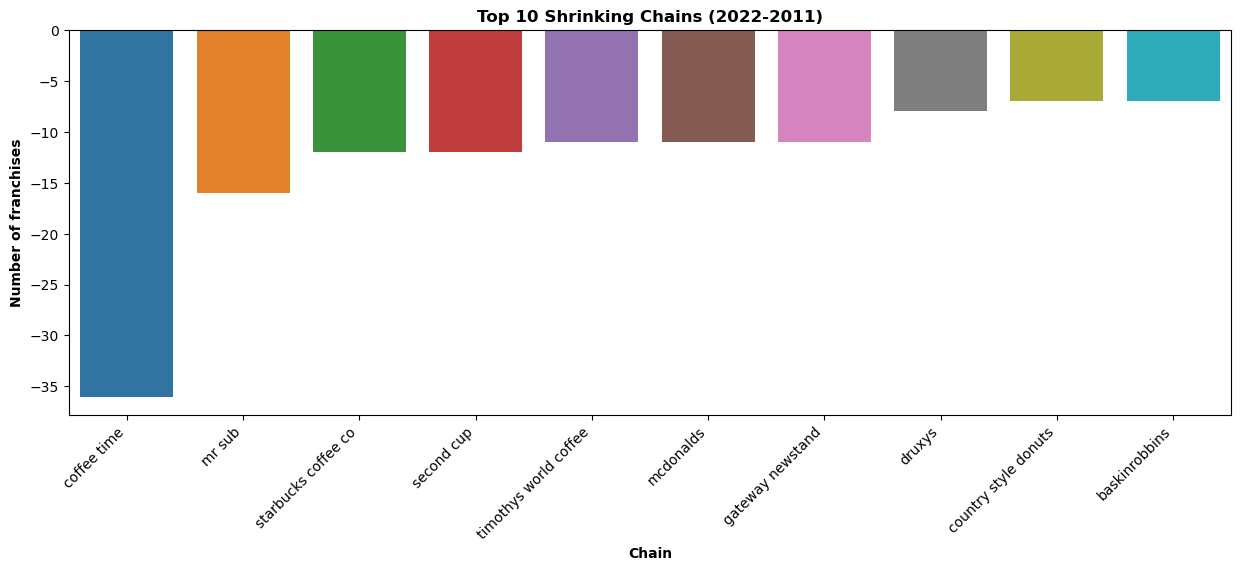

In [34]:
plt.figure(figsize=(15,5))
plt.title('Top 10 Shrinking Chains (2022-2011)', fontsize='large', fontweight='bold')
sns.barplot(data = ds_growth.sort_values('count_diff_2022_2011', ascending=True).head(10), x='chain', y='count_diff_2022_2011')
plt.xlabel('Chain', fontweight='bold')
plt.ylabel('Number of franchises', fontweight='bold')
plt.xticks(rotation=45,horizontalalignment='right')
plt.show()

In [35]:
ds_grouped_2 = dinesafe.groupby(['Year', 'STATUS', 'NAME']).agg(
    counts = ('ID', 'nunique')
).sort_values(['Year', 'counts'], ascending=[False, False]).reset_index()

In [36]:
ds_grouped_2.loc[ds_grouped_2['counts']<3, ['NAME']] = 'not_chain'
ds_grouped_2.loc[ds_grouped_2['counts']>=3, ['NAME']] = 'chain'

In [37]:
ds_grouped_2['NAME'].value_counts()

not_chain    211611
chain          5486
Name: NAME, dtype: int64

In [38]:
ds_grouped_3 = ds_grouped_2.groupby(['Year', 'STATUS', 'NAME']).agg('sum').reset_index()

In [39]:
ds_grouped_3['STATUS'].value_counts()

Conditional Pass    44
Pass                44
Out of Business     28
Closed              22
Name: STATUS, dtype: int64

In [40]:
ds_grouped_3['STATUS'] = ds_grouped_3['STATUS'].map({'Out of Business':'Not_Pass',
                                                     'Closed':'Not_Pass',
                                                     'Conditional Pass':'Not_Pass',
                                                     'Pass':'Pass'})

In [41]:
ds_grouped_3

,Year,STATUS,NAME,counts
0,2001,Not_Pass,not_chain,5
1,2001,Not_Pass,chain,23
2,2001,Not_Pass,not_chain,875
3,2001,Pass,chain,359
4,2001,Pass,not_chain,2907
...,...,...,...,...
133,2022,Not_Pass,not_chain,989
134,2022,Not_Pass,chain,229
135,2022,Not_Pass,not_chain,1846
136,2022,Pass,chain,2996


In [42]:
test = pd.pivot_table(ds_grouped_3, values='counts', index='Year', columns=['STATUS', 'NAME']).reset_index()
test

STATUS  Year Not_Pass                 Pass          
NAME            chain    not_chain   chain not_chain
0       2001     23.0   440.000000   359.0    2907.0
1       2002     15.0   236.666667   445.0    3246.0
2       2003     17.0   334.000000   590.0    3899.0
3       2004     16.0   196.666667   688.0    4344.0
4       2005     14.0   190.333333   782.0    4961.0
5       2006      6.0   165.000000   997.0    5567.0
6       2007     20.0   240.333333  1211.0    6104.0
7       2008     27.0   430.000000  1476.0    6745.0
8       2009     41.0   297.333333  1563.0    6862.0
9       2010     56.0   413.333333  2097.0    8392.0
10      2011    104.0   725.500000  2377.0    9141.0
11      2012     48.0   511.000000  2590.0    9910.0
12      2013     64.5   729.333333  3192.0   11776.0
13      2014    211.0  1421.666667  3554.0   12757.0
14      2015    196.0  1144.333333  3432.0   12231.0
15      2016    189.0  1138.333333  3392.0   12030.0
16      2017    169.5  1091.333333  3469.0   12394.0
17      2018    184.0  1200.000000  3469.0   12236.0
18      2019    194.5  1353.333333  3661.0   12768.0
19      2020     41.0   424.666667  2162.0    6648.0
20      2021     56.5   427.666667  1428.0    4870.0
21      2022    150.0   950.000000  2996.0    9449.0

In [43]:
test['chain_fail_rate'] = test['Not_Pass']['chain']/test['Pass']['chain']*100
test['not_chain_fail_rate'] = test['Not_Pass']['not_chain']/test['Pass']['not_chain']*100

In [44]:
test

STATUS  Year Not_Pass                 Pass           chain_fail_rate  \
NAME            chain    not_chain   chain not_chain                   
0       2001     23.0   440.000000   359.0    2907.0        6.406685   
1       2002     15.0   236.666667   445.0    3246.0        3.370787   
2       2003     17.0   334.000000   590.0    3899.0        2.881356   
3       2004     16.0   196.666667   688.0    4344.0        2.325581   
4       2005     14.0   190.333333   782.0    4961.0        1.790281   
5       2006      6.0   165.000000   997.0    5567.0        0.601805   
6       2007     20.0   240.333333  1211.0    6104.0        1.651528   
7       2008     27.0   430.000000  1476.0    6745.0        1.829268   
8       2009     41.0   297.333333  1563.0    6862.0        2.623161   
9       2010     56.0   413.333333  2097.0    8392.0        2.670482   
10      2011    104.0   725.500000  2377.0    9141.0        4.375263   
11      2012     48.0   511.000000  2590.0    9910.0        1.853282   
12      2013     64.5   729.333333  3192.0   11776.0        2.020677   
13      2014    211.0  1421.666667  3554.0   12757.0        5.936972   
14      2015    196.0  1144.333333  3432.0   12231.0        5.710956   
15      2016    189.0  1138.333333  3392.0   12030.0        5.571934   
16      2017    169.5  1091.333333  3469.0   12394.0        4.886134   
17      2018    184.0  1200.000000  3469.0   12236.0        5.304122   
18      2019    194.5  1353.333333  3661.0   12768.0        5.312756   
19      2020     41.0   424.666667  2162.0    6648.0        1.896392   
20      2021     56.5   427.666667  1428.0    4870.0        3.956583   
21      2022    150.0   950.000000  2996.0    9449.0        5.006676   

STATUS not_chain_fail_rate  
NAME                        
0                15.135879  
1                 7.291025  
2                 8.566299  
3                 4.527317  
4                 3.836592  
5                 2.963894  
6                 3.937309  
7                 6.375093  
8                 4.333042  
9                 4.925326  
10                7.936768  
11                5.156408  
12                6.193388  
13               11.144208  
14                9.356008  
15                9.462455  
16                8.805336  
17                9.807127  
18               10.599415  
19                6.387886  
20                8.781656  
21               10.053974

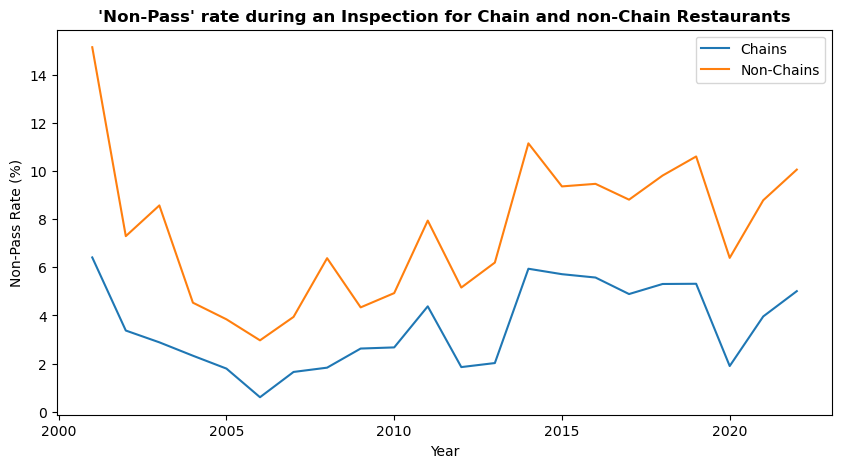

In [47]:
plt.figure(figsize=(10,5))
plt.title('\'Non-Pass\' rate during an Inspection for Chain and non-Chain Restaurants', fontsize='large', fontweight='bold')
sns.lineplot(data = test, x='Year', y='chain_fail_rate', label='Chains')
sns.lineplot(data = test, x='Year', y='not_chain_fail_rate', label='Non-Chains')
plt.xlabel('Year')
plt.ylabel('Non-Pass Rate (%)')
plt.show()